In [62]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.measure import find_contours
from skimage.segmentation import watershed
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
import os
import random

### ABCF 이미지 로드

In [63]:
def show_image(image, title='Image'):
    if image is not None:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()

In [64]:
def show_image_new(image, title='Image'):
    # 이미지를 uint8 형식으로 변환
    image_uint8 = (image * 255).astype(np.uint8)
    
    # 이미지 출력
    if image_uint8 is not None:
        plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print("이미지를 불러올 수 없습니다.")

In [65]:
def load_images_in_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]
    images = {}
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        images[image_file] = image_path
    return images

In [66]:
def load_images_in_folders(folders):
    images_in_folders = {}
    for folder_name, folder_path in folders.items():
        images_in_folders[folder_name] = load_images_in_folder(folder_path)
    return images_in_folders


In [67]:
folder_A = "A"
folder_B = "B"
folder_C = "C"
folder_F = "F"
folders = {
    'A': folder_A,
    'B': folder_B,
    'C': folder_C,
    'F': folder_F
}

In [68]:
images_in_folders = load_images_in_folders(folders)

In [69]:
images_in_folders

{'A': {'setimg6_sb_381_Liniya 1id61_2393.png': 'A/setimg6_sb_381_Liniya 1id61_2393.png',
  'Liniya 1id331_6385.png': 'A/Liniya 1id331_6385.png',
  'setimg6_sb_400_Liniya 1id68_2470.png': 'A/setimg6_sb_400_Liniya 1id68_2470.png',
  'setimg6_sb_354_Liniya 1id53_2044.png': 'A/setimg6_sb_354_Liniya 1id53_2044.png',
  'setimg5_labeling_196_Liniya 1id85_2227.png': 'A/setimg5_labeling_196_Liniya 1id85_2227.png',
  'setimg6_sb_247_Liniya 1id15_835.png': 'A/setimg6_sb_247_Liniya 1id15_835.png',
  'setimg5_labeling_194_Liniya 1id49_1451.png': 'A/setimg5_labeling_194_Liniya 1id49_1451.png',
  'setimg6_sb_379_Liniya 1id61_2372.png': 'A/setimg6_sb_379_Liniya 1id61_2372.png',
  'setimg6_sb_278_Liniya 1id23_902.png': 'A/setimg6_sb_278_Liniya 1id23_902.png',
  'setimg4_labelimg_20_Liniya 1id271_5134.png': 'A/setimg4_labelimg_20_Liniya 1id271_5134.png',
  'setimg6_sb_305_Liniya 1id2_460.png': 'A/setimg6_sb_305_Liniya 1id2_460.png',
  'setimg6_sb_314_Liniya 1id3_146.png': 'A/setimg6_sb_314_Liniya 1id3_1

In [ ]:
def preprocess_images_and_find_contours(images_in_folders):
    processed_images = {}
    contours_dict = {}

    for label, images in images_in_folders.items():
        for image_name, image_path in images.items():
            image = cv2.imread(image_path)
            
            if image is not None:
                # 이미지를 그레이스케일로 변환
                image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                # 이미지를 float 타입으로 변환
                image_gray = img_as_float(image_gray)

                # 강조와 약화를 위한 마스크 생성
                mask_strong = image_gray >= 0.7
                mask_weak = (image_gray < 0.4) & (image_gray >= 0)

                # 마스크를 사용하여 강조 및 약화 적용
                image_strong = image_gray.copy()
                image_weak = image_gray.copy()

                image_strong[mask_strong] = image_strong[mask_strong] * 1.2  # 강조
                image_weak[mask_weak] = image_weak[mask_weak] * 0.7  # 약화

                # 두 이미지 합치기
                image_combined = np.maximum(image_strong, image_weak)

                # Otsu 이진화 적용
                thresh = threshold_otsu(image_gray)
                image_binary = image_gray > thresh

                # 컨투어 찾기
                contours = find_contours(image_gray, level=0.6)

                # 이미지 정보 및 컨투어 정보 저장
                image_label = f"{label}_{image_name}"
                processed_images[image_label] = {
                    'gray': image_gray,
                    'combined': image_combined,
                    'binary': image_binary
                }
                contours_dict[image_label] = contours

    return processed_images, contours_dict


In [71]:
processed_images, contours_dict = preprocess_images_and_find_contours(images_in_folders)

In [72]:
def plot_contours(image_gray, contours, title='Contour'):
    plt.figure(figsize=(8, 8))
    plt.imshow(image_gray, cmap='gray')
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [73]:
def plot_contours_for_image(images_in_folders, processed_images, contours_dict, label, index, image_name):
    image_label = f"{label}_{image_name}"
    contours = contours_dict[image_label]
    image_gray = processed_images[image_label]['gray']
    plot_contours(image_gray, contours, title=f'Contours for {image_label}')

In [74]:
def plot_random_contours(images_in_folders, processed_images, contours_dict, label):
    images = images_in_folders[label]
    image_name = random.choice(list(images.keys()))
    plot_contours_for_image(images_in_folders, processed_images, contours_dict, label, 1, image_name)


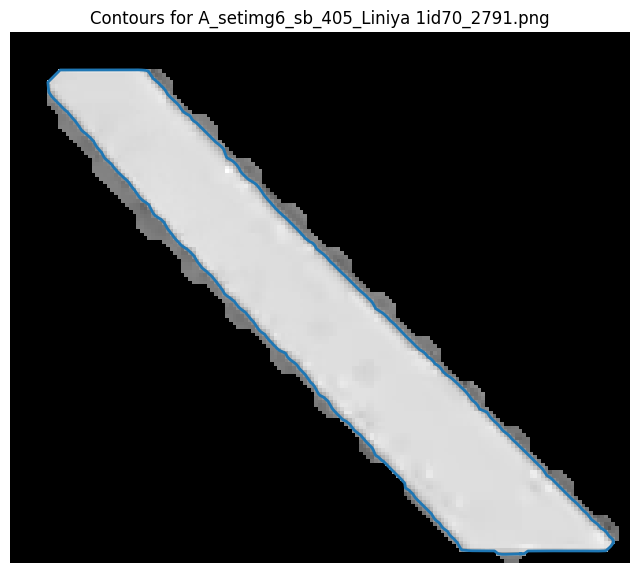

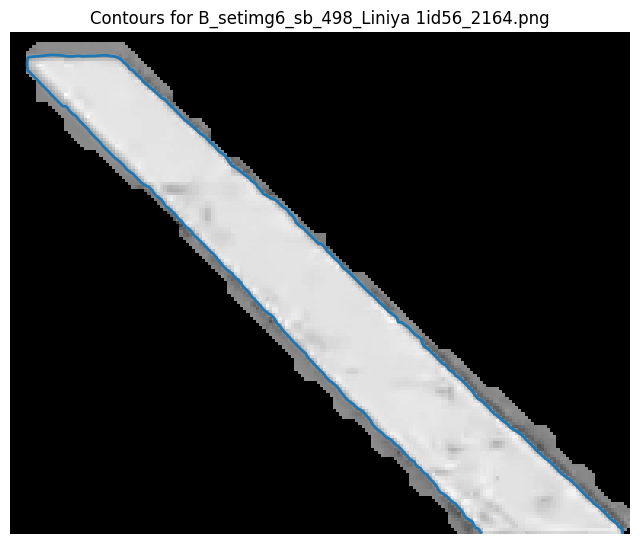

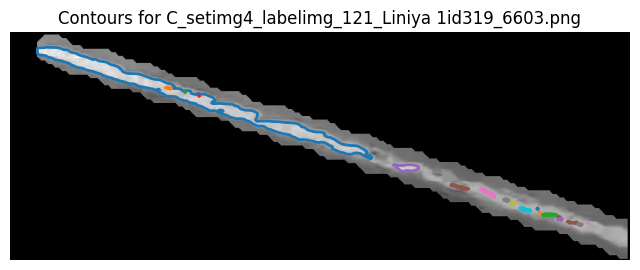

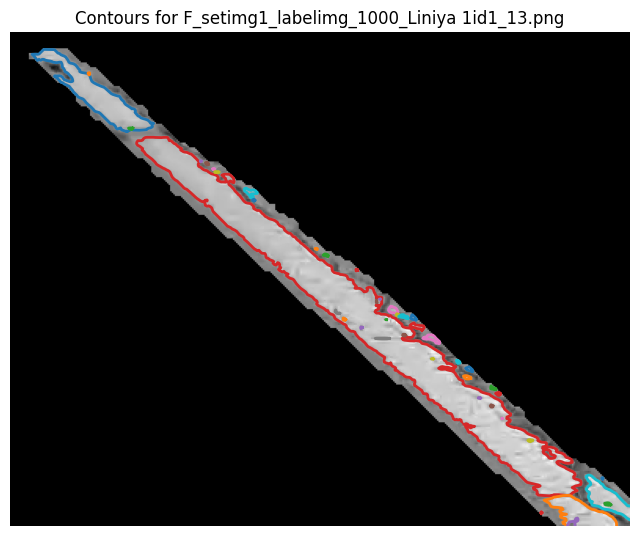

In [75]:
label_list = ["A", "B", "C", "F"]
for label in label_list:
    plot_random_contours(images_in_folders, processed_images, contours_dict, label)


In [96]:
def calculate_contour_stats(processed_images, contours_dict, labels):
    contour_counts = {label: [] for label in labels}
    contour_areas = {label: [] for label in labels}
    image_counts = {label: 0 for label in labels}

    for label in labels:
        for image_name in processed_images.keys():
            if image_name.startswith(label):
                image_counts[label] += 1
                contours = contours_dict[image_name]
                contour_counts[label].append(len(contours))
                contour_areas[label].append(sum([cv2.contourArea(np.array(contour, dtype=np.float32)) for contour in contours]))

    total_contour_counts = {label: sum(contour_counts[label]) for label in labels}
    total_contour_areas = {label: sum(contour_areas[label]) for label in labels}
    avg_contour_counts = {label: total_contour_counts[label] / image_counts[label] for label in labels}
    avg_contour_areas = {label: total_contour_areas[label] / image_counts[label] for label in labels}

    return total_contour_counts, total_contour_areas, avg_contour_counts, avg_contour_areas, image_counts


In [94]:
def plot_histograms(avg_contour_counts, avg_contour_areas, labels):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot average contour counts
    ax_count = axs[0]
    ax_count.bar(labels, avg_contour_counts.values(), color='skyblue', edgecolor='black', alpha=0.7)
    ax_count.set_title('Average Contour Counts for Each Label')
    ax_count.set_xlabel('Labels')
    ax_count.set_ylabel('Average Contour Counts')
    ax_count.grid(True)

    # Plot average contour areas
    ax_area = axs[1]
    ax_area.bar(labels, avg_contour_areas.values(), color='orange', edgecolor='black', alpha=0.7)
    ax_area.set_title('Average Contour Areas for Each Label')
    ax_area.set_xlabel('Labels')
    ax_area.set_ylabel('Average Contour Area')
    ax_area.grid(True)

    plt.tight_layout()
    plt.show()

In [101]:
total_contour_counts, total_contour_areas, avg_contour_counts, avg_contour_areas, image_counts = calculate_contour_stats(processed_images, contours_dict, labels)

print("레이블당 이미지 갯수:")
for label in labels:
    print(f"{label}: {image_counts[label]}")
print()

print("각 레이블당 토탈 컨투어 갯수:")
for label in labels:
    print(f"{label}: {total_contour_counts[label]}")
print()

print("각 레이블당 토탈 컨투어 면적:")
for label in labels:
    print(f"{label}: {total_contour_areas[label]}")
print()


레이블당 이미지 갯수:
A: 292
B: 154
C: 145
F: 117

각 레이블당 토탈 컨투어 갯수:
A: 1853
B: 1255
C: 2126
F: 2661

각 레이블당 토탈 컨투어 면적:
A: 1817723.313534851
B: 1196719.4034250705
C: 771195.9199108074
F: 374544.2429042043



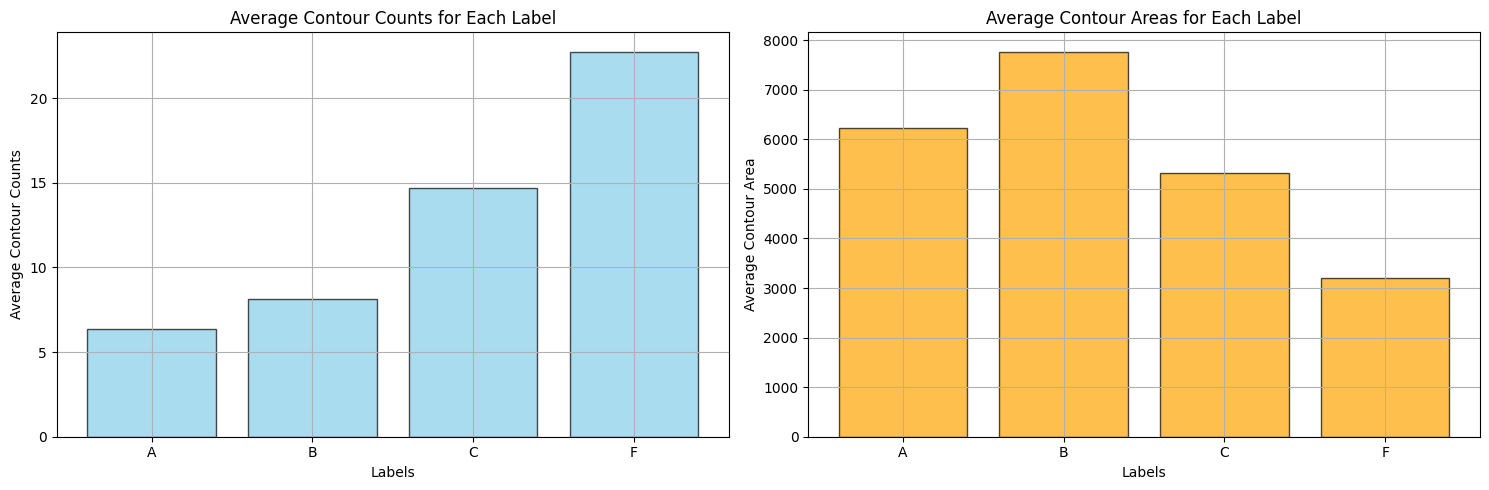

In [95]:
# 각 레이블의 컨투어 통계 계산
labels = ["A", "B", "C", "F"]
avg_contour_counts, avg_contour_areas = calculate_contour_stats(processed_images, contours_dict, labels)

# 히스토그램 그리기
plot_histograms(avg_contour_counts, avg_contour_areas, labels)

### 판단